In [1]:
#default_exp data.datasets.epf

# EPF dataset

> API details.

In [2]:
#export
from dataclasses import dataclass
from datetime import timedelta
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
from pandas.tseries.frequencies import to_offset

from nixtla.data.datasets.utils import download_file, Info, TimeSeriesDataclass
from nixtla.data.tsdataset import TimeSeriesDataset

In [3]:
#export
SOURCE_URL = 'https://sandbox.zenodo.org/api/files/da5b2c6f-8418-4550-a7d0-7f2497b40f1b/'

Electricity Price Forecasting meta information

In [4]:
#export
@dataclass
class NP:
    test_date: str = '2016-12-27'
    name: str = 'NP'

@dataclass
class PJM:
    test_date: str = '2016-12-27'
    name: str = 'PJM'

@dataclass
class BE:
    test_date: str = '2015-01-04'
    name: str = 'BE'

@dataclass
class FR:
    test_date: str = '2015-01-04'
    name: str = 'FR'

@dataclass
class DE:
    test_date: str = '2016-01-04'
    name: str = 'DE'

In [5]:
#export
EPFInfo = Info(groups=('NP', 'PJM', 'BE', 'FR', 'DE'),
               class_groups=(NP, PJM, BE, FR, DE))

In [6]:
#export
class EPF:

    @staticmethod
    def load(directory: str,
             group: str) -> Tuple[pd.DataFrame, 
                                  Optional[pd.DataFrame], 
                                  Optional[pd.DataFrame]]:
        """
        Downloads and loads EPF data.

        Parameters
        ----------
        directory: str
            Directory where data will be downloaded.
        group: str
            Group name.
            Allowed groups: 'NP', 'PJM', 'BE', 'FR', 'DE'.
        """
        path = Path(directory) / 'epf' / 'datasets'

        EPF.download(directory)

        class_group = EPFInfo.get_group(group)

        file = path / f'{group}.csv'

        df = pd.read_csv(file)

        df.columns = ['ds', 'y'] + \
                     [f'Exogenous{i}' for i in range(1, len(df.columns) - 1)]

        df['unique_id'] = group
        df['ds'] = pd.to_datetime(df['ds'])
        df['week_day'] = df['ds'].dt.dayofweek

        dummies = pd.get_dummies(df['week_day'], prefix='day')
        df = pd.concat([df, dummies], axis=1)

        dummies_cols = [col for col in df \
                        if (col.startswith('day') or col.startswith('hour_'))]

        Y = df.filter(items=['unique_id', 'ds', 'y'])
        X = df.filter(items=['unique_id', 'ds', 'Exogenous1', 'Exogenous2', 'week_day'] + \
                      dummies_cols)
        
        return Y, X, None

    @staticmethod
    def load_groups(directory: str,
                    groups: List[str]) -> Tuple[pd.DataFrame, 
                                                Optional[pd.DataFrame], 
                                                Optional[pd.DataFrame]]:
        """
        Downloads and loads panel of EPF data
        according of groups.

        Parameters
        ----------
        directory: str
            Directory where data will be downloaded.
        groups: List[str]
            Group names.
            Allowed groups: 'NP', 'PJM', 'BE', 'FR', 'DE'.
        """
        Y = []
        X = []
        for group in groups:
            Y_df, X_df, S_df = EPF.load(directory=directory, group=group)
            Y.append(Y_df)
            X.append(X_df)
            
        Y = pd.concat(Y).sort_values(['unique_id', 'ds']).reset_index(drop=True)
        X = pd.concat(X).sort_values(['unique_id', 'ds']).reset_index(drop=True)

        S = Y[['unique_id']].drop_duplicates().reset_index(drop=True)
        dummies = pd.get_dummies(S['unique_id'], prefix='static')
        S = pd.concat([S, dummies], axis=1)
        
        return Y, X, S
    
    @staticmethod
    def download(directory: str) -> None:
        """Downloads EPF Dataset."""
        path = Path(directory) / 'epf' / 'datasets'
        if not path.exists():
            for group in EPFInfo.groups:
                download_file(path, SOURCE_URL + f'{group}.csv')

## Load specific group

In [7]:
args = pd.Series({'dataset': 'NP'})

Y_df, Xt_df, _ = EPF.load(directory='data', group=args.dataset)

# train_mask: 1 to keep, 0 to mask
offset = 365 * 24 * 2
train_outsample_mask = np.ones(len(Y_df))
train_outsample_mask[-offset:] = 0

print(f'Dataset: {args.dataset}')
#print("Xt_df.columns", Xt_df.columns)
print(f'Train mask percentage: {np.round(np.sum(train_outsample_mask)/len(train_outsample_mask),2)}')
print('X: time series features, of shape (#hours, #times,#features): \t' + str(Xt_df.shape))
print('Y: target series (in X), of shape (#hours, #times): \t \t' + str(Y_df.shape))
print(f'Last ds {Y_df.ds.max()}')
print(f'Train {sum(1-train_outsample_mask)} hours = {np.round(sum(1-train_outsample_mask)/(24*365),2)} years')
print(f'Validation {sum(train_outsample_mask)} hours = {np.round(sum(train_outsample_mask)/(24*365),2)} years')
# print('S: static features, of shape (#series,#features): \t \t' + str(S.shape))
#Y_df.head()
print('\n')

100%|██████████| 2.12M/2.12M [00:01<00:00, 1.67MiB/s]
INFO:nixtla.data.datasets.utils:Successfully downloaded NP.csv, 2118914, bytes.
100%|██████████| 2.53M/2.53M [00:01<00:00, 1.95MiB/s]
INFO:nixtla.data.datasets.utils:Successfully downloaded PJM.csv, 2530311, bytes.
100%|██████████| 1.97M/1.97M [00:01<00:00, 1.88MiB/s]
INFO:nixtla.data.datasets.utils:Successfully downloaded BE.csv, 1974555, bytes.
100%|██████████| 2.00M/2.00M [00:02<00:00, 800kiB/s] 
INFO:nixtla.data.datasets.utils:Successfully downloaded FR.csv, 1996871, bytes.
100%|██████████| 2.10M/2.10M [00:01<00:00, 2.00MiB/s]
INFO:nixtla.data.datasets.utils:Successfully downloaded DE.csv, 2095831, bytes.
Dataset: NP
Train mask percentage: 0.67
X: time series features, of shape (#hours, #times,#features): 	(52416, 12)
Y: target series (in X), of shape (#hours, #times): 	 	(52416, 3)
Last ds 2018-12-24 23:00:00
Train 17520.0 hours = 2.0 years
Validation 34896.0 hours = 3.98 years




## Load all groups

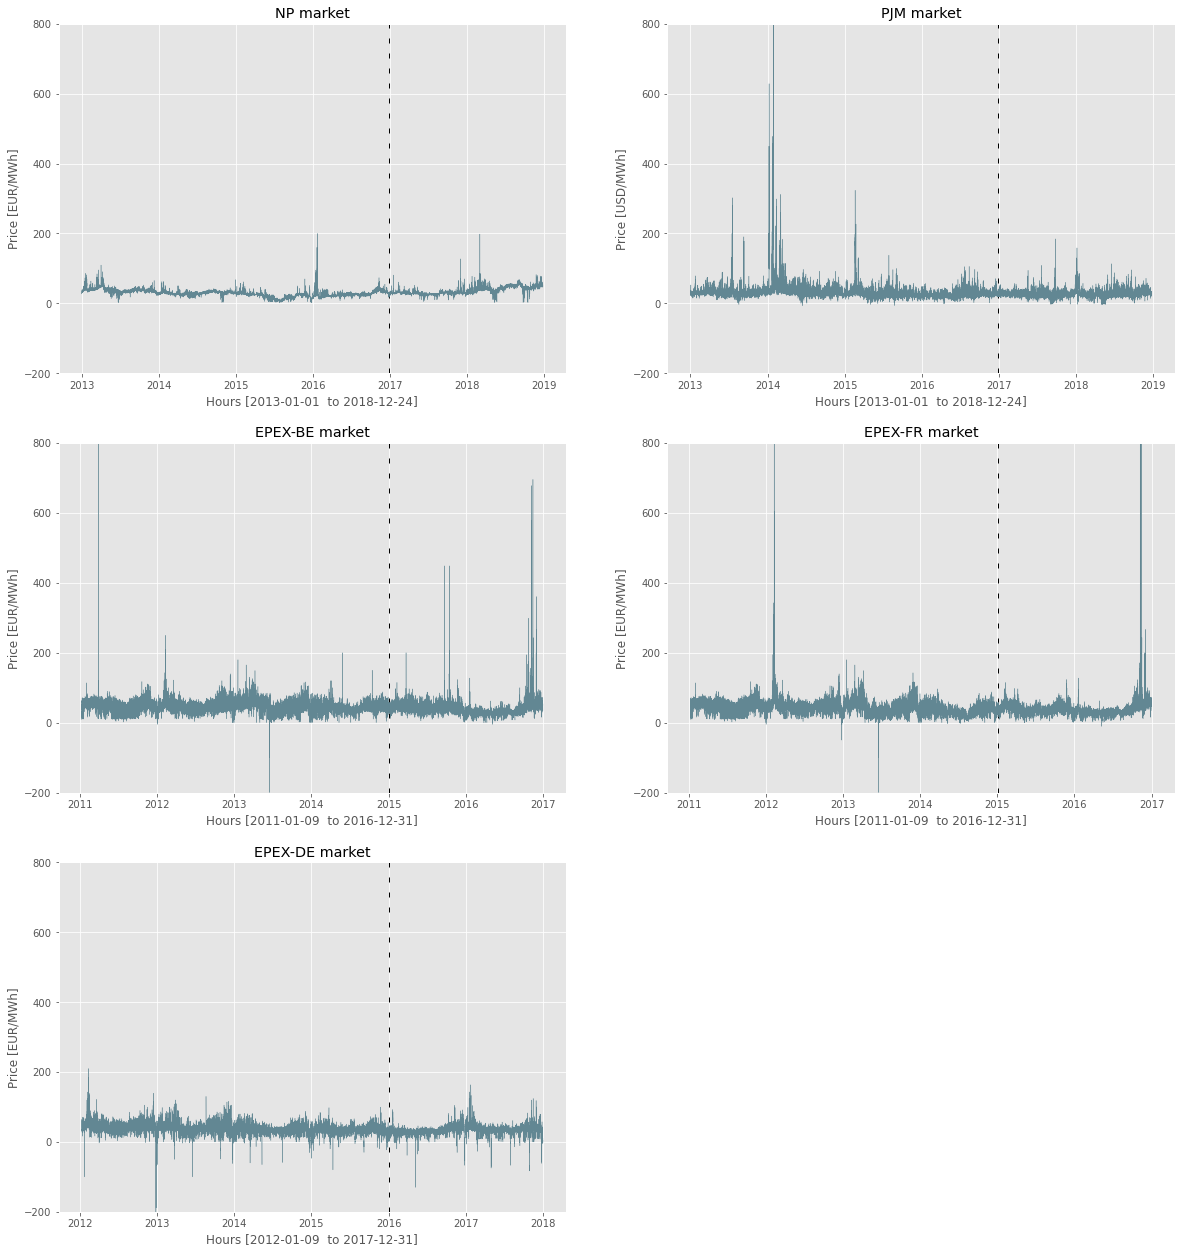

In [8]:
import os
if not os.path.exists('./results/'):
    os.makedirs('./results/')

import pylab as plt
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = 15, 15

from nixtla.data.datasets.epf import EPF, EPFInfo

dataset = ['NP', 'PJM', 'BE', 'FR', 'DE']
Y_df, X_df, S_df = EPF.load_groups(directory='data', groups=dataset)

fig = plt.figure(figsize=(20, 15))
fig.tight_layout()
plt.ylim(-200, 800)
rcParams['figure.figsize'] = 15, 15
ax0 = plt.subplot2grid((3,2),(0, 0))
ax1 = plt.subplot2grid((3,2),(0, 1))
ax2 = plt.subplot2grid((3,2),(1, 0))
ax3 = plt.subplot2grid((3,2),(1, 1))
ax4 = plt.subplot2grid((3,2),(2, 0))
axs = [ax0, ax1, ax2, ax3, ax4]

for idx, market in enumerate(dataset):
    currency = 'USD' if market == 'PJM' else 'EUR'
    title_str  = 'EPEX-' if not (market in ['PJM', 'NP']) else ''
    title_str += f'{market} market'
    y_axis_str = f'Price [{currency}/MWh]'

    x_plot = Y_df[Y_df.unique_id==market].ds.values
    y_plot = Y_df[Y_df.unique_id==market].y.values
    
    x_axis_str = f'Hours [{str(x_plot.min())[:10]}  to {str(x_plot.max())[:10]}]'


    axs[idx].plot(x_plot, y_plot, color='#628793', linewidth=0.4)
    axs[idx].set_xlabel(x_axis_str)
    axs[idx].vlines(x_plot[-728*24],-200,800, linestyle=(0, (5, 10)), 
                    color='black', linewidth=1.)
    axs[idx].set_ylabel(y_axis_str)
    axs[idx].set_title(title_str)
    axs[idx].set_ylim(-200,800)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=1.2, wspace=0.2, hspace=0.2)
plt.savefig('./results/market_plots.png', bbox_inches = 'tight')
plt.show()

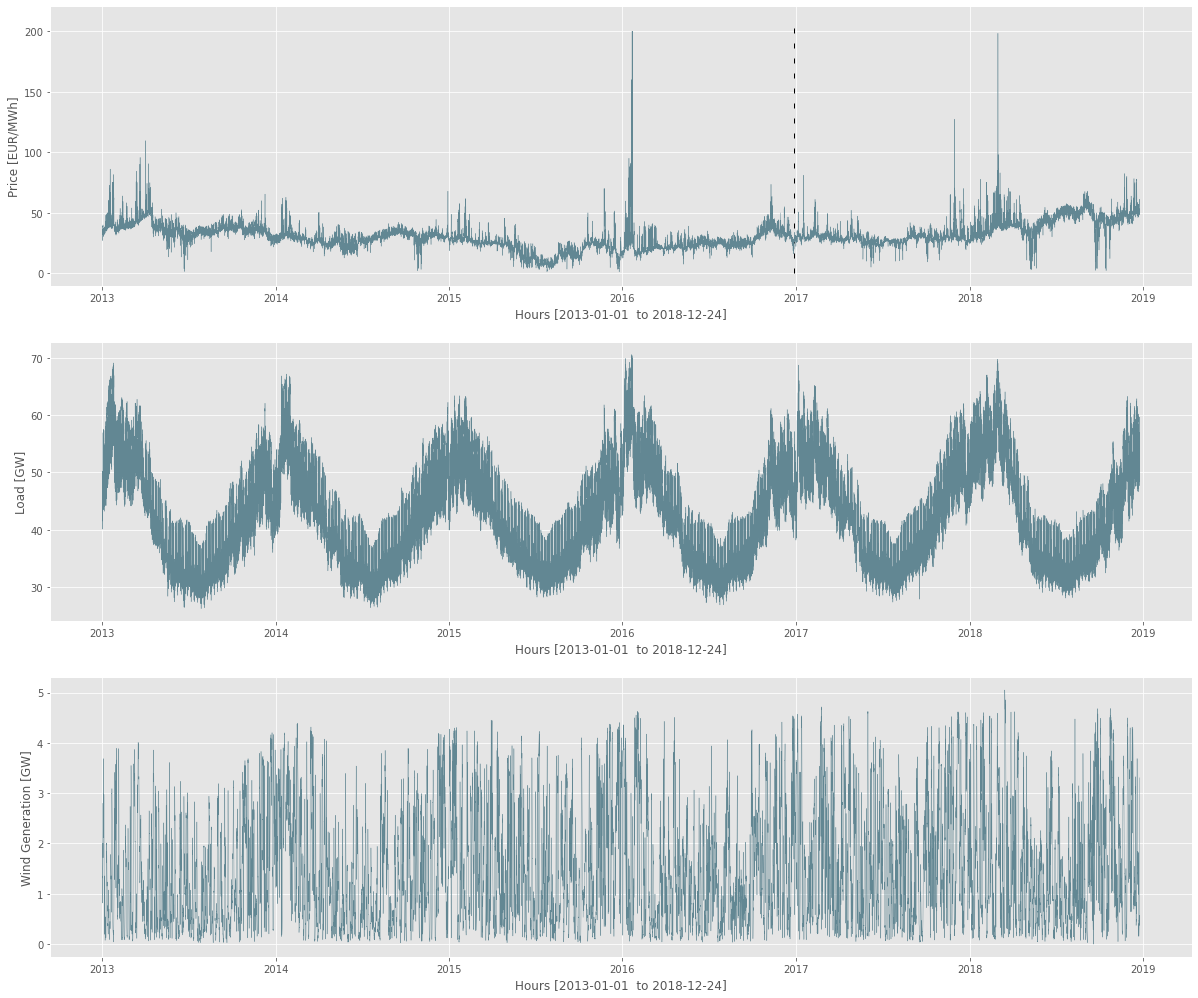

In [9]:
import pylab as plt
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = 15, 15

from nixtla.data.datasets.epf import EPF, EPFInfo

EXOGENOUS_NAMES = {'NP': ['Load [GW]', 'Wind Generation [GW]'],
                    'PJM': ['Load [GW]', 'COMED Load [GW]'],
                    'BE': ['Load [GW]', 'Total France Generation [GW]'],
                    'FR': ['Load [GW]', 'Total France Generation [GW]'],
                    'DE': ['TSO Zonal Load [GW]', 'DE Wind Generation [GW]']}

# dataset = ['NP', 'PJM', 'BE', 'FR', 'DE']
dataset = ['NP']
# dataset = ['DE']
Y_df, X_df, S_df = EPF.load_groups(directory='data', groups=dataset)

fig = plt.figure(figsize=(45, 12))
fig.tight_layout()
plt.ylim(-200, 800)
rcParams['figure.figsize'] = 15, 15
ax0 = plt.subplot2grid((3,2),(0, 0))
ax1 = plt.subplot2grid((3,2),(1, 0))
ax2 = plt.subplot2grid((3,2),(2, 0))
axs = [ax0, ax1, ax2]

# for idx, market in enumerate(dataset):
market = dataset[0]
currency = 'USD' if market == 'PJM' else 'EUR'
title_str  = 'EPEX-' if not (market in ['PJM', 'NP']) else ''
title_str += f'{market} market'
y_axis_str = f'Price [{currency}/MWh]'

x_plot = Y_df.ds.values
x_axis_str = f'Hours [{str(x_plot.min())[:10]}  to {str(x_plot.max())[:10]}]'

y_plot = Y_df.y.values
x1_plot = X_df.Exogenous1.values
x2_plot = X_df.Exogenous2.values

axs[0].plot(x_plot, y_plot, color='#628793', linewidth=0.4)
axs[0].set_xlabel(x_axis_str)
axs[0].set_ylabel(y_axis_str)
#axs[0].vlines(x_plot[-728*24],-250,280, linestyle=(0, (5, 10)), 
#              color='black', linewidth=1.)
axs[0].vlines(x_plot[-728*24],0,210, linestyle=(0, (5, 10)), 
                color='black', linewidth=1.)              

axs[1].plot(x_plot, x1_plot/1000, color='#628793', linewidth=0.4)
axs[1].set_xlabel(x_axis_str)
axs[1].set_ylabel(EXOGENOUS_NAMES[market][0])

axs[2].plot(x_plot, x2_plot/1000, color='#628793', linewidth=0.4)
axs[2].set_xlabel(x_axis_str)
axs[2].set_ylabel(EXOGENOUS_NAMES[market][1])

# # axs[idx].set_title(title_str)
# axs[idx].set_ylim(-200,800)
# # print(\x_plot[-728*24]\, x_plot[-728*24])

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=1.2, wspace=0.2, hspace=0.2)
# plt.savefig('./results/market_plots.pdf', bbox_inches = 'tight')
# plt.savefig('./results/NP.pdf', bbox_inches = 'tight')
plt.show()